### Please install the required Python modules/SDKs

In [1]:
! activate ai-azure-c1

import sys

sys.path.append("/opt/conda/envs/ai-azure-c1/lib/python3.8/site-packages")

Could not find conda environment: ai-azure-c1
You can list all discoverable environments with `conda info --envs`.



## Please use this Jupyter Notebook to write the above exercise solution
### Importing utility functions and Python modules

In [2]:
import requests
from urllib.parse import urlparse
from io import BytesIO
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

import os, time, uuid

from azure.cognitiveservices.vision.customvision.training import CustomVisionTrainingClient
from azure.cognitiveservices.vision.customvision.prediction import CustomVisionPredictionClient
from azure.cognitiveservices.vision.customvision.training.models import ImageFileCreateBatch, ImageFileCreateEntry, Region
from msrest.authentication import ApiKeyCredentials

### Make sure you have correct Training and Prediction Endpoint, Key and Resource ID separately

#### You will need:
- Azure Custom Vision Endpoint
- Traning Reource ID and Key
- Prediction Resource ID and Key

In [3]:
TRAINING_ENDPOINT = "https://nayanacustomvision.cognitiveservices.azure.com/"
training_key = "ce08598caf404621b37136119dccd921"
training_resource_id = '/subscriptions/bb272072-9c6d-4e28-b814-947814c3e6ef/resourceGroups/nayana-ai-msft-azure/providers/Microsoft.CognitiveServices/accounts/nayanacustomvision'

In [4]:
PREDICTION_ENDPOINT = 'https://nayanacustomvision-prediction.cognitiveservices.azure.com/'
prediction_key = "6b7c1fe2bea0431a8a3b4259749591e6"
prediction_resource_id = "/subscriptions/bb272072-9c6d-4e28-b814-947814c3e6ef/resourceGroups/nayana-ai-msft-azure/providers/Microsoft.CognitiveServices/accounts/nayanacustomvision-Prediction"

### Instantiate and authenticate the training client with endpoint and key 

In [5]:
training_credentials = ApiKeyCredentials(in_headers={"Training-key": training_key})
trainer = CustomVisionTrainingClient(TRAINING_ENDPOINT, training_credentials)

In [6]:
trainer.api_version

'3.4-preview'

### TODO: Creating Your Training Project

In [7]:
# Todo: create a new project
print ("Training project created. Please move on.")
project_name = 'ForkOrScissor'
# To change the project classification type, you can set classification_type = 'Multiclass'.
project = trainer.create_project(project_name)

# Getting Project Details as collective information 
project.as_dict()

Training project created. Please move on.


{'id': '17ecba91-40d9-47e2-a7ba-b65009067ebd',
 'name': 'ForkOrScissor',
 'description': '',
 'settings': {'domain_id': 'ee85a74c-405e-4adc-bb47-ffa8ca0c9f31',
  'classification_type': 'Multilabel',
  'target_export_platforms': [],
  'use_negative_set': True,
  'image_processing_settings': {'augmentation_methods': {'rotation': True,
    'scaling': True,
    'translation': True,
    'horizontal flip': True,
    'equalize': True,
    'solarize': True,
    'padtosquare': True}}},
 'created': '2022-06-19T19:05:28.030Z',
 'last_modified': '2022-06-19T19:05:28.030Z',
 'dr_mode_enabled': False,
 'status': 'Succeeded'}

### TODO: Adding Tags Based on Training Requirements

In [8]:
# Todo: add tags to the training project, make sure to change 'tag_name' based on the classes/labels
fork_tag = trainer.create_tag(project.id, "Fork")
scissor_tag = trainer.create_tag(project.id, "Scissor")

### TODO: Upload Traning Data

In [9]:
# Code taken from Azure SDK Sample. No need to change it
def upload_images_for_training(local_project_id, local_img_folder_name, image_tag_id):
    image_list = []
    files = os.listdir(os.path.join (local_image_path, local_img_folder_name))
    for file in files:
        full_path = os.path.join(local_image_path, local_img_folder_name, file)
        if os.path.isfile(full_path) and full_path.endswith('.jpeg'):
            with open(os.path.join (local_image_path, local_img_folder_name, file), "rb") as image_contents:
                image_list.append(ImageFileCreateEntry(name=file, contents=image_contents.read(), tag_ids=[image_tag_id]))
                
    upload_result = trainer.create_images_from_files(local_project_id, ImageFileCreateBatch(images=image_list))
    if not upload_result.is_batch_successful:
        print("Image batch upload failed.")
        for image in upload_result.images:
            print("Image status: ", image.status)
        exit(-1)
    return upload_result

In [10]:
# Todo: update the image path
local_image_path = ''

# Todo: upload images. Make sure to upload images for ALL classes/tags
scissor_upload_result = upload_images_for_training(project.id, 'scissor-images', scissor_tag.id)
fork_upload_result = upload_images_for_training(project.id, 'fork-images', fork_tag.id)

In [11]:
# Todo: check if images for ALL tags are successfully uploaded.
scissor_upload_result.is_batch_successful
fork_upload_result.is_batch_successful

True

### TODO: Start the Image Classification Training

In [12]:
# Todo: set the train_project object
iteration = trainer.train_project(project.id)

# We will be keep checking every 10 seconds the training progress
while (iteration.status != "Completed"):
    iteration = trainer.get_iteration(project.id, iteration.id)
    print ("Training status: " + iteration.status)
    print ("Waiting 10 seconds...")
    time.sleep(10)

Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 sec

### TODO: Get the Model Performance

In [13]:
iteration.as_dict()

{'id': '266eb522-38f9-4738-9163-fa0f709cdc05',
 'name': 'Iteration 1',
 'status': 'Completed',
 'created': '2022-06-19T19:05:28.030Z',
 'last_modified': '2022-06-19T19:11:47.930Z',
 'trained_at': '2022-06-19T19:11:47.925Z',
 'project_id': '17ecba91-40d9-47e2-a7ba-b65009067ebd',
 'exportable': False,
 'domain_id': 'ee85a74c-405e-4adc-bb47-ffa8ca0c9f31',
 'classification_type': 'Multilabel',
 'training_type': 'Regular',
 'reserved_budget_in_hours': 0,
 'training_time_in_minutes': 4}

In [14]:
iteration_list = trainer.get_iterations(project.id)
for iteration_item in iteration_list:
    print(iteration_item)

{'additional_properties': {}, 'id': '266eb522-38f9-4738-9163-fa0f709cdc05', 'name': 'Iteration 1', 'status': 'Completed', 'created': datetime.datetime(2022, 6, 19, 19, 5, 28, 30000, tzinfo=<isodate.tzinfo.Utc object at 0x7f92cf5c95b0>), 'last_modified': datetime.datetime(2022, 6, 19, 19, 11, 47, 930000, tzinfo=<isodate.tzinfo.Utc object at 0x7f92cf5c95b0>), 'trained_at': datetime.datetime(2022, 6, 19, 19, 11, 47, 925000, tzinfo=<isodate.tzinfo.Utc object at 0x7f92cf5c95b0>), 'project_id': '17ecba91-40d9-47e2-a7ba-b65009067ebd', 'exportable': False, 'exportable_to': None, 'domain_id': 'ee85a74c-405e-4adc-bb47-ffa8ca0c9f31', 'classification_type': 'Multilabel', 'training_type': 'Regular', 'reserved_budget_in_hours': 0, 'training_time_in_minutes': 4, 'publish_name': None, 'original_publish_resource_id': None, 'custom_base_model_info': None, 'training_error_details': None}


In [15]:
# Todo: get the model performance
model_perf = trainer.get_iteration_performance(project.id, iteration_list[0].id)

In [16]:
# Evaluate model performance by looking at the precision and recall values.
model_perf.as_dict()

{'per_tag_performance': [{'id': '92c9d8c5-93d6-4243-9627-00333085a101',
   'name': 'Fork',
   'precision': 1.0,
   'precision_std_deviation': 0.0,
   'recall': 1.0,
   'recall_std_deviation': 0.0,
   'average_precision': 1.0},
  {'id': 'ce8ee5f8-59b5-4216-a8ae-4d80e11ee3b8',
   'name': 'Scissor',
   'precision': 1.0,
   'precision_std_deviation': 0.0,
   'recall': 1.0,
   'recall_std_deviation': 0.0,
   'average_precision': 1.0}],
 'precision': 1.0,
 'precision_std_deviation': 0.0,
 'recall': 1.0,
 'recall_std_deviation': 0.0,
 'average_precision': 1.0}

### TODO: Add more images and perform more training iterations to improve your model performance.

In [17]:
# more training here...

### TODO: Publishing the Model to the Project Endpoint

In [18]:
# Todo: set the Iteration Name. This will be used when Model training is completed
publish_iteration_name = "udacity-class-classification-fork-or-scissor"

In [19]:
# Todo: publish it to the project endpoint
trainer.publish_iteration(project.id, iteration.id, publish_iteration_name, prediction_resource_id)
print ("Done!")

Done!


### TODO: Performing Prediction

In [20]:
# Instantiate and authenticate the prediction client with endpoint and key
prediction_credentials = ApiKeyCredentials(in_headers={"Prediction-key": prediction_key})
predictor = CustomVisionPredictionClient(PREDICTION_ENDPOINT, prediction_credentials)
predictor.api_version

'3.1'

In [21]:
# Todo: define a function to use the predictor object.
def perform_prediction(image_file_name):
    with open(os.path.join (local_image_path,  image_file_name), "rb") as image_contents:
        # Todo: set the predictor object to classify the image.
        results = predictor.classify_image(project.id, publish_iteration_name, image_contents.read())
        # Display the results.
        for prediction in results.predictions:
            print("\t" + prediction.tag_name +
                  ": {0:.2f}%".format(prediction.probability * 100))

In [22]:
# Todo: set the image that you want to perform prediction. Make sure the image is under the right path.
file_name = 'test_image.jpeg'
local_image_path = 'test-fork-or-scissor'

In [23]:
# Todo: call the perform_prediction function to make the prediction
perform_prediction(file_name)

	Fork: 100.00%
	Scissor: 0.00%


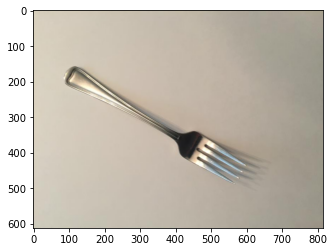

In [24]:
# Check the Image
with open(os.path.join (local_image_path, file_name), 'rb') as img_code:
    img_view_ready = Image.open(img_code)
    plt.figure()
    plt.imshow(img_view_ready)

### Export Model (optional)
You can download the model so it can be used outside Azure. Note: this step may take a very long time.

In [35]:
print("Project ID: ", project.id)

Project ID:  17ecba91-40d9-47e2-a7ba-b65009067ebd


In [36]:
all_iterations = trainer.get_iterations(project.id)

In [37]:
# Check if the iteration is exportable
for index, each_iteration in enumerate(all_iterations):
    print("|--------- Iteration [{}] --------".format(index))
    print("Iteration ID: ",each_iteration.id)
    print("Iteration Name: ",each_iteration.name)
    print("Iteration Exportable: ",each_iteration.exportable)
    print("-----------------------------------------------------")

|--------- Iteration [0] --------
Iteration ID:  25e976ae-0796-48a9-a99f-99b089a4bee3
Iteration Name:  Iteration 2
Iteration Exportable:  True
-----------------------------------------------------
|--------- Iteration [1] --------
Iteration ID:  266eb522-38f9-4738-9163-fa0f709cdc05
Iteration Name:  Iteration 1
Iteration Exportable:  False
-----------------------------------------------------


Above please verify that your project-> Iteration must be exportalble
- Iteration Exportable: True

Make sure there are exportable iterations. If none of the iteration is exportable, follow these steps:
* Go to the Custom Vision portal
* Select a project and change your project setting to support the compact domain
* Create another iteration for model training

You can check the *"Azure Custom Vision Portal Demo 5: Export a Model"* video for how to perform these steps.

Then you can rerun the cells above.

In [38]:
# Todo: change the all_iterations index. Make sure the iterations is the exportable.
selected_iteration_id = all_iterations[0].id
print(selected_iteration_id)

25e976ae-0796-48a9-a99f-99b089a4bee3


In [39]:
# Using the TensorFlow platform
platform = "TensorFlow"
flavor = "TensorFlowLite"

In [40]:
# Use the export object to expert the project and trained model
export_process = trainer.export_iteration(project.id, selected_iteration_id, platform, flavor, raw=True)

In [41]:
print(export_process.output)

{'additional_properties': {}, 'platform': 'TensorFlow', 'status': 'Exporting', 'download_uri': None, 'flavor': 'TensorFlowLite', 'newer_version_available': False}


In [42]:
print(export_process.output.status)

Exporting


In [ ]:
# Code snippet is from Azure SDK and Documentation
# https://docs.microsoft.com/en-us/azure/cognitive-services/custom-vision-service/export-programmatically
# Note: this step may take long time 
while (export_process.output.status == "Exporting"):
    print ("Waiting 10 seconds...")
    time.sleep(10)
    exports = trainer.get_exports(project.id, selected_iteration_id)
    for e in exports:
        if e.platform == export_process.output.platform and e.flavor == export_process.output.flavor:
            export = e
            break
    print("Export status is: ", export_process.output.status)

Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export st

Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Wa

Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Wa

Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Wa

Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Wa

Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Wa

Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Wa

Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Wa

Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Wa

Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Wa

Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Wa

Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Wa

Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Wa

Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Waiting 10 seconds...
Export status is:  Exporting
Wa

In [ ]:
print(export_process.output.status)

In [ ]:
print(export_process.output.download_uri)

In [ ]:
## Downloading the model from url
if export_process.output.status == "Done":
    # Ready to Download. You can choose any preferred name of the file.
    model_export_file = requests.get(export_process.output.download_uri)
    with open("model.zip", "wb") as file:
        file.write(model_export_file.content)